In [1]:
import sys
sys.path.insert(0, '/Users/orentapiero/MyResearch') 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm 
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from FILTERS.utilities import strided_app
from FILTERS.wavelet_transform import WT

from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
from statsmodels.graphics.tsaplots import plot_acf

set_loky_pickler()

plt.rcParams['figure.figsize'] = [10,8]
sns.set()
tqdm.pandas()

In [54]:
data = pd.read_csv('/Users/orentapiero/Data/binance_ETHUSDT_1m.csv') #bitmex_BTCUSD_1m
data.index = pd.to_datetime(data['time'],unit = 's')
del data['time']
ohlc = data.loc[:'2021-12-31'].copy()

ohlc['time'] = ohlc.index
grouper = ohlc.groupby(ohlc.index.strftime('%Y-%m-%d %H'))

OHLC = [grouper['open'].first().rename('open'),
        grouper['high'].max().rename('high'),
        grouper['low'].min().rename('low'),
        grouper['close'].last().rename('close'),
        grouper['volume'].sum().rename('Volume')]

OHLC = pd.concat(OHLC,axis=1)
OHLC.index = pd.to_datetime(OHLC.index)
OHLC = OHLC.loc[OHLC.Volume>0]

In [55]:
from arch import arch_model
from arch.univariate import ARX,GARCH,HARX

def garch_runner(OHLC,dates):
    ohlc = OHLC.loc[dates].copy()

    Rm = 10000*np.log(ohlc[['open','close']].mean(1)).diff().dropna()
    Rc = 10000*np.log(ohlc['close']).diff().dropna()

    arx = HARX(Rm, lags=[1,3,6],rescale=False)
    arx.volatility = GARCH()
    res = arx.fit(disp = 'off')
    forc = res.forecast(horizon = 1,reindex = False)
    mu,vol = forc.mean.values[0][0],np.sqrt(forc.variance.values[0][0])

    out = dict(date = Rm.index[-1],
               Close = ohlc.close.iloc[-1],
               mid = ohlc[['open','close']].mean(1).iloc[-1],
               Rm = Rm.iloc[-1],
               Rc = Rc.iloc[-1],
               pred = mu,
               vol = vol)
    return out

def direc(output,var):
    pos = (output[var]>0) & (output['pred'].shift(1) > 0)
    neg = (output[var]<=0) & (output['pred'].shift(1) <= 0)
    mask = pos | neg
    return mask.sum()/mask.count()

In [56]:
strided_dates = strided_app(OHLC.index.values,1000,1)

fun = delayed(garch_runner)
iteration = tqdm(range(strided_dates.shape[0]))

output = Parallel(n_jobs=-1)(fun(OHLC,strided_dates[t]) for t in iteration)
output = pd.DataFrame(output)
output.index = pd.to_datetime(output.date)
del output['date']

  0%|          | 0/37218 [00:00<?, ?it/s]

In [57]:
output['predicted_pmid'] = output['Close']*np.exp(output['pred']/10000)
output['Rmid2cl'] = 10000*np.log(output['Close']/output['mid'].shift(1))

In [58]:
error_m2m = 10000*np.log(output['mid']/output['predicted_pmid'].shift(1))
error_c2m = 10000*np.log(output['Close']/output['predicted_pmid'].shift(1))

RMSE_m2m = error_m2m.groupby(error_m2m.index.year).apply(lambda x: np.sqrt((x**2).mean())).rename('RMSE_m2m')
RMSE_c2m = error_c2m.groupby(error_c2m.index.year).apply(lambda x: np.sqrt((x**2).mean())).rename('RMSE_c2m')
RMSE_m2m.loc['All'] = np.sqrt((error_m2m**2).mean())
RMSE_c2m.loc['All'] = np.sqrt((error_c2m**2).mean())

MAD_m2m = error_m2m.abs().groupby(error_m2m.index.year).mean().rename('MAD_m2m')
MAD_c2m = error_c2m.abs().groupby(error_m2m.index.year).mean().rename('MAD_c2m')
MAD_m2m.loc['All'] = error_m2m.abs().mean()
MAD_c2m.loc['All'] = error_c2m.abs().mean()

MDA_m2m = output.groupby(output.index.year).apply(lambda x: direc(x,'Rm')).rename('MDA_m2m')
MDA_m2m.loc['All'] = direc(output,'Rm')

MDA_c2m = output.groupby(output.index.year).apply(lambda x: direc(x,'Rmid2cl')).rename('MDA_c2m')
MDA_c2m.loc['All'] = direc(output,'Rmid2cl')

MDA_c2c = output.groupby(output.index.year).apply(lambda x: direc(x,'Rc')).rename('MDA_c2c')
MDA_c2c.loc['All'] = direc(output,'Rc')

pd.concat([RMSE_m2m,RMSE_c2m,MAD_m2m,MAD_c2m,MDA_m2m,MDA_c2m,MDA_c2c],axis = 1)

,RMSE_m2m,RMSE_c2m,MAD_m2m,MAD_c2m,MDA_m2m,MDA_c2m,MDA_c2c
date,,,,,,,
2017,92.049422,160.593038,60.164225,101.970085,0.612039,0.556239,0.446837
2018,82.622837,142.346324,53.135544,90.263380,0.649270,0.583630,0.464881
2019,51.795710,89.919570,33.698417,56.608143,0.636582,0.574619,0.458710
2020,60.439739,105.534996,38.231003,65.209053,0.643053,0.577116,0.465092
2021,72.881760,125.052865,51.216866,86.285184,0.663503,0.598331,0.479991
All,69.653473,120.448123,45.043832,76.247456,0.645978,0.581842,0.466011


In [59]:
RMSE_0_6 = np.sqrt((error_c2m.between_time('00:00','06:00')**2).mean())
RMSE_7_12 = np.sqrt((error_c2m.between_time('07:00','12:00')**2).mean())
RMSE_13_16 = np.sqrt((error_c2m.between_time('13:00','16:00')**2).mean())
RMSE_17_23 = np.sqrt((error_c2m.between_time('17:00','23:00')**2).mean())

print('00-06:',RMSE_0_6)
print('07-12:',RMSE_7_12)
print('13-16:',RMSE_13_16)
print('17-23:',RMSE_17_23)

00-06: 117.51239970970587
07-12: 116.34502290659512
13-16: 135.54531660368565
17-23: 117.58718701698368


In [60]:
MAE_0_6 = ((error_c2m.abs().between_time('00:00','06:00')).mean())
MAE_7_12 = ((error_c2m.abs().between_time('07:00','12:00')).mean())
MAE_13_16 = ((error_c2m.abs().between_time('13:00','16:00')).mean())
MAE_17_23 = ((error_c2m.abs().between_time('17:00','23:00')).mean())

print('00-06:',MAE_0_6)
print('07-12:',MAE_7_12)
print('13-16:',MAE_13_16)
print('17-23:',MAE_17_23)

00-06: 73.9214944066807
07-12: 74.78759246278021
13-16: 86.1864001596441
17-23: 74.1345244262147


In [61]:
def count_intersections(blend_ohlc_):
    return (blend_ohlc_.close > blend_ohlc_.predicted_pmid).astype(float).diff().abs().sum()

def ttinter(blend_ohlc_):
    inter = (blend_ohlc_.close > blend_ohlc_.predicted_pmid).astype(float).diff().abs()
    if inter.sum()>0:
        ttm = inter.loc[inter==1].index[0]-blend_ohlc_.index[0]
    else:
        ttm = pd.Timedelta(np.nan)
    return ttm

In [62]:
output=output.groupby(output.index).first()
ohlc=ohlc.groupby(ohlc.index).first()

In [63]:
spread = 10000*np.log(output['predicted_pmid']/OHLC['close']).rename('spread').dropna()
spread = spread.groupby(spread.index).first()
blend_ohlc = pd.concat([ohlc[['open','high','low','close']],
                        output['predicted_pmid'],
                        spread],axis = 1).fillna(method = 'ffill').dropna()


In [64]:
sp = spread.copy()
sp.index = pd.to_datetime(sp.index)

print(sp.abs().between_time('00:00','06:00').mean())
print(sp.abs().between_time('07:00','12:00').mean())
print(sp.abs().between_time('13:00','16:00').mean())
print(sp.abs().between_time('17:00','23:00').mean())

print(sp.abs().groupby(sp.index.year).mean())

24.35444856847855
23.66705780276096
27.356116486915052
24.34086349251626
2017    28.201793
2018    28.820279
2019    18.379357
2020    20.510973
2021    30.112434
Name: spread, dtype: float64


In [65]:
intersect = blend_ohlc.groupby(blend_ohlc.index.strftime('%Y-%m-%d %H')).apply(count_intersections).rename('n_inter')
ttm = blend_ohlc.groupby(blend_ohlc.index.strftime('%Y-%m-%d %H')).apply(ttinter).rename('t2inter')
spread = blend_ohlc.groupby(blend_ohlc.index.strftime('%Y-%m-%d %H')).first()
mspread = blend_ohlc.spread.abs().groupby(blend_ohlc.index.strftime('%Y-%m-%d %H')).min().rename('min_spr')
mspread1 = (blend_ohlc.spread**2).groupby(blend_ohlc.index.strftime('%Y-%m-%d %H')).min().rename('min_spr1')

res = pd.concat([intersect,ttm,spread,mspread,mspread1],axis = 1)
res.index = pd.to_datetime(res.index)


In [66]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].describe().copy()
summary1.loc['count'] /= len(res)


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

38.57518034851622


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.632546,1.000000,1.000000e+00
mean,3.352247,0 days 00:23:51.364424057,24.680016,1.488045e+03
std,3.782993,0 days 00:18:10.013552420,29.647343,6.352230e+03
min,0.000000,0 days 00:00:14,0.000545,2.975043e-07
25%,0.000000,0 days 00:07:00,6.888456,4.745083e+01
50%,2.000000,0 days 00:21:00,15.602178,2.434280e+02
75%,6.000000,0 days 00:39:00,31.664801,1.002660e+03
max,33.000000,0 days 00:59:00,663.535538,4.402794e+05


In [67]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].between_time('00:00','06:00').describe()
summary1.loc['count'] /= len(res.between_time('00:00','06:00'))
print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

38.212409903662326


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.623972,1.000000,1.000000e+00
mean,3.304685,0 days 00:23:41.838862559,24.354813,1.460188e+03
std,3.777187,0 days 00:18:00.490117444,29.446757,6.926270e+03
min,0.000000,0 days 00:00:20,0.000545,2.975043e-07
25%,0.000000,0 days 00:07:00,6.694631,4.481809e+01
50%,2.000000,0 days 00:20:00,15.467360,2.392392e+02
75%,6.000000,0 days 00:39:00,31.031907,9.629793e+02
max,27.000000,0 days 00:59:00,663.535538,4.402794e+05


In [68]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].between_time('07:00','12:00').describe()
summary1.loc['count'] /= len(res.between_time('07:00','12:00'))
print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

37.08003730516998


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.639149,1.000000,1.000000
mean,3.332473,0 days 00:24:14.860746720,23.667058,1374.929167
std,3.708304,0 days 00:18:16.882256699,28.546228,6238.263067
min,0.000000,0 days 00:00:20,0.001904,0.000004
25%,0.000000,0 days 00:07:00,6.700572,44.897677
50%,2.000000,0 days 00:21:00,15.021869,225.656537
75%,6.000000,0 days 00:40:00,30.264379,915.932777
max,26.000000,0 days 00:59:00,538.726543,290226.287620


In [69]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].between_time('13:00','16:00').describe()
summary1.loc['count'] /= len(res.between_time('13:00','16:00'))
print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

42.95877281517874


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.644294,1.000000,1.000000
mean,3.349751,0 days 00:23:53.079190607,27.355952,1845.456162
std,3.706840,0 days 00:18:12.320557516,33.125287,7479.005070
min,0.000000,0 days 00:00:20,0.002189,0.000005
25%,0.000000,0 days 00:06:00,7.564897,57.227672
50%,2.000000,0 days 00:21:00,17.322060,300.053774
75%,6.000000,0 days 00:39:00,35.091539,1231.416143
max,27.000000,0 days 00:59:00,498.778870,248780.361491


In [70]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].between_time('17:00','23:00').describe()
summary1.loc['count'] /= len(res.between_time('17:00','23:00'))
print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

37.528652947713205


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.628721,1.000000,1.000000
mean,3.417861,0 days 00:23:39.343855034,24.341628,1408.399792
std,3.893010,0 days 00:18:11.940464255,28.565012,5002.343738
min,0.000000,0 days 00:00:14,0.007262,0.000053
25%,0.000000,0 days 00:06:40,6.859967,47.059142
50%,2.000000,0 days 00:20:00,15.394189,236.981067
75%,6.000000,0 days 00:39:00,31.531356,994.226438
max,33.000000,0 days 00:59:00,421.427724,177601.326443


In [80]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].loc['2017'].describe().copy()
summary1.loc['count'] /= len(res.loc['2017'])


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

43.908451408944266


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.663005,1.000000,1.000000
mean,4.680141,0 days 00:22:40.702451954,28.201793,1927.952105
std,5.199964,0 days 00:18:09.107041637,33.661682,5936.077129
min,0.000000,0 days 00:00:20,0.017313,0.000300
25%,0.000000,0 days 00:06:00,7.543558,56.905466
50%,3.000000,0 days 00:19:00,17.497183,306.151461
75%,8.000000,0 days 00:38:00,35.150635,1235.569378
max,33.000000,0 days 00:59:00,329.062817,108282.337773


In [81]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].loc['2018'].describe().copy()
summary1.loc['count'] /= len(res.loc['2018'])


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

45.1747766155911


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.630647,1.000000,1.000000
mean,3.279113,0 days 00:24:30.631425446,28.820279,2040.760442
std,3.752462,0 days 00:18:01.402157819,34.789238,8078.327664
min,0.000000,0 days 00:00:14,0.005791,0.000034
25%,0.000000,0 days 00:08:00,8.074978,65.205279
50%,2.000000,0 days 00:22:00,18.506662,342.496538
75%,6.000000,0 days 00:40:00,36.707581,1347.446518
max,23.000000,0 days 00:59:00,498.778870,248780.361491


In [82]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].loc['2019'].describe().copy()
summary1.loc['count'] /= len(res.loc['2019'])


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

29.291955422604527


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.659414,1.000000,1.000000
mean,3.336464,0 days 00:24:06.022924626,18.380993,858.018652
std,3.581943,0 days 00:18:20.098999522,22.808273,3482.130478
min,0.000000,0 days 00:01:00,0.001904,0.000004
25%,0.000000,0 days 00:07:00,5.192861,26.965805
50%,2.000000,0 days 00:21:00,11.566877,133.792640
75%,6.000000,0 days 00:40:00,22.774977,518.699580
max,27.000000,0 days 00:59:00,347.686374,120885.814682


In [83]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].loc['2020'].describe().copy()
summary1.loc['count'] /= len(res.loc['2020'])


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

32.54018428918429


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.639443,1.000000,1.000000e+00
mean,3.308429,0 days 00:23:39.889404209,20.511637,1.058864e+03
std,3.596428,0 days 00:18:17.121262026,25.262801,7.144963e+03
min,0.000000,0 days 00:01:00,0.000545,2.975043e-07
25%,0.000000,0 days 00:06:00,6.153001,3.785942e+01
50%,2.000000,0 days 00:20:00,13.692388,1.874815e+02
75%,6.000000,0 days 00:39:00,26.632148,7.092714e+02
max,23.000000,0 days 00:59:00,663.535538,4.402794e+05


In [84]:
summary1 = res[['n_inter','t2inter','min_spr','min_spr1']].loc['2021'].describe().copy()
summary1.loc['count'] /= len(res.loc['2021'])


print(np.sqrt(summary1.loc['mean'].loc['min_spr1']))
summary1

43.39359362614784


,n_inter,t2inter,min_spr,min_spr1
count,1.000000,0.592775,1.000000,1.000000
mean,3.139133,0 days 00:23:26.511089681,30.112226,1883.003968
std,3.685338,0 days 00:17:58.880823863,31.246911,5769.708793
min,0.000000,0 days 00:01:00,0.003826,0.000015
25%,0.000000,0 days 00:07:00,9.399636,88.353170
50%,2.000000,0 days 00:20:00,21.037067,442.558170
75%,5.000000,0 days 00:38:00,40.245692,1619.715825
max,21.000000,0 days 00:59:00,447.279871,200059.283074


<AxesSubplot:xlabel='time'>

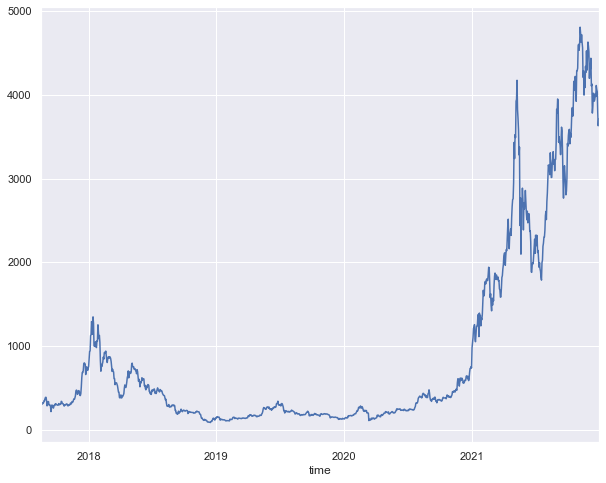

In [85]:
OHLC.close.resample('1B').last().plot()

In [89]:
res.loc[res.spread>100].dropna()

,n_inter,t2inter,open,high,low,close,predicted_pmid,spread,min_spr,min_spr1
2017-10-13 06:00:00,2.0,0 days 00:51:00,317.55,317.55,315.20,316.01,337.055969,189.769007,189.769007,36012.276076
2017-10-24 02:00:00,8.0,0 days 00:10:00,302.98,302.99,301.01,302.96,306.479886,115.183381,115.183381,13267.211172
2017-11-30 08:00:00,2.0,0 days 00:26:00,434.47,434.47,431.87,431.87,446.351587,102.496619,102.496619,10505.556843
2017-12-12 00:00:00,2.0,0 days 00:01:20,507.00,509.99,505.99,509.69,514.861801,116.469826,116.469826,13565.220298
2017-12-12 13:00:00,2.0,0 days 00:07:20,548.52,551.00,548.18,548.22,564.205935,110.603549,110.603549,12233.145080
...,...,...,...,...,...,...,...,...,...,...
2021-05-23 21:00:00,4.0,0 days 00:15:00,2066.18,2068.47,2062.33,2066.68,2115.937326,100.541325,100.541325,10108.557954
2021-05-24 12:00:00,2.0,0 days 00:41:00,2367.66,2379.63,2360.73,2362.25,2461.604289,157.284333,157.284333,24738.361359
2021-05-25 00:00:00,4.0,0 days 00:43:00,2647.92,2649.00,2632.43,2632.97,2744.204047,120.370262,120.370262,14488.999915
2021-05-26 02:00:00,2.0,0 days 00:27:00,2762.03,2779.06,2761.82,2774.99,2826.877321,111.581237,111.581237,12450.372371


Text(0.5, 1.0, 'Market and Predicted ETHUSD 2021-05-25')

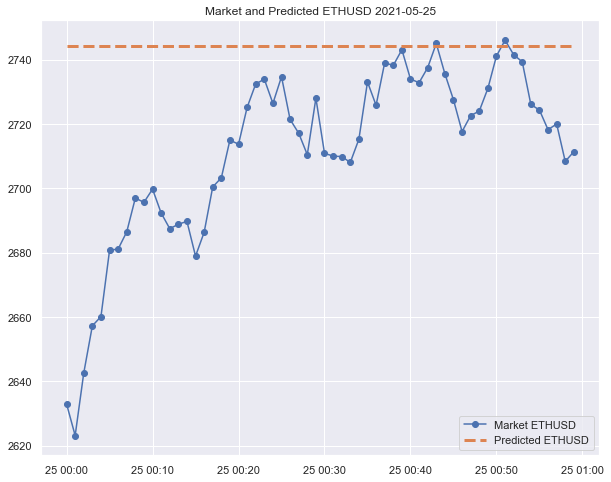

In [90]:
z = blend_ohlc.loc['2021-05-25 00:00:00':'2021-05-25 00:59:00',('predicted_pmid','close')].copy()
z.columns = ['Predicted ETHUSD','Market ETHUSD']



plt.plot(z['Market ETHUSD'],'o-',label = 'Market ETHUSD')
plt.plot(z['Predicted ETHUSD'],'--',label = 'Predicted ETHUSD',linewidth = 3)
plt.legend()
plt.title('Market and Predicted ETHUSD 2021-05-25')

In [88]:
z

,Predicted BTCUSD,Market BTCUSD
2021-12-04 05:00:00,3801.392907,4030.00
2021-12-04 05:01:00,3801.392907,4005.13
2021-12-04 05:02:00,3801.392907,3977.34
2021-12-04 05:03:00,3801.392907,3882.47
2021-12-04 05:04:00,3801.392907,3931.94
2021-12-04 05:05:00,3801.392907,3923.84
2021-12-04 05:06:00,3801.392907,3918.55
2021-12-04 05:07:00,3801.392907,3879.09
2021-12-04 05:08:00,3801.392907,3889.03
2021-12-04 05:09:00,3801.392907,3931.73
